In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram as xhist
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter 
import matplotlib.colors as colors
import re
import cmocean as cmo
from shapely.geometry import Polygon, Point

In [2]:
out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_americas/"
year_list = np.arange(2007,2017).tolist()
out_files = sorted(Path(out_path).glob("*.nc"))
output_dt_in_h = 24


def read_output(file):    
    return xr.open_dataset(file)

def load_ds(zone = 1):
    
    out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_americas/"
    out_files = sorted(Path(out_path).glob(f"*zone{zone}*.nc"))

    ds = xr.concat(map(read_output, out_files), dim="traj")
    print(f'loaded {len(out_files)} files in zone {zone}')
    return ds, len(out_files)

def calculate_heatmap(output_dataset, lat_bins=None, lon_bins=None):
    heat_map = xhist(
        output_dataset.lat,
        output_dataset.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj"],
    )
    
    heat_map = heat_map.where(heat_map > 0)
        
    return heat_map

def calc_mort_heatmap(data, lat_bins,lon_bins,photo = False ):
    
    data = data.copy()

    if photo:
        print('mortality; with photos.')
        m = -0.092683473
        data = data.isel(obs = slice(0,181))

    else:
        print('mortality; without photos.')
        m = -0.164783335
        data = data.isel(obs = slice(0,101))

    t = data.obs
    n0 = data.traj.size
    weight = xr.ones_like(data.obs)
    int_heat = calculate_heatmap(data.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins)
    mort_heatmap = (int_heat * weight[:-1]).sum('obs')
    #analytical integ. particles
    particle_sum = int(np.sum(n0 * np.exp(m*t)))
    #diff to integ.mortality heatmap
    err_diff = mort_heatmap.sum()-particle_sum
    print(f'Difference to integr. particles: {err_diff.values}')

    return mort_heatmap,weight#particle_sum

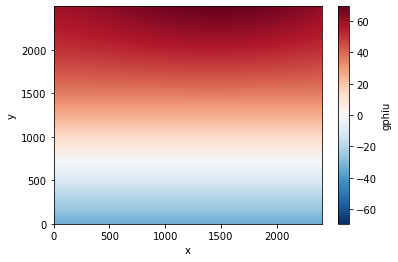

In [18]:
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")
VIK_mask = xr.open_dataset('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/1_mesh_mask.nc')
VIK_mask

In [20]:
u_pat = [f"1_VIKING20X.L46-KFS003_1m_{year}*grid_U.nc" for year in year_list]
v_pat = [f"1_VIKING20X.L46-KFS003_1m_{year}*grid_V.nc" for year in year_list]

u_files = []
v_files = []
for i,upat in enumerate(u_pat):
    
    u_files.extend(Path(data_path).glob(u_pat[i]))
    v_files.extend(Path(data_path).glob(v_pat[i]))

In [21]:
u_files[:2]

[PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_20070101_20071231_grid_U.nc'),
 PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_20080101_20081231_grid_U.nc')]

In [22]:

u_lat = VIK_mask.gphiu.squeeze()
u_lon = VIK_mask.glamu.squeeze()
v_lat = VIK_mask.gphiu.squeeze()
v_lon = VIK_mask.glamv.squeeze()

box = ((VIK_mask.nav_lat >= -10) & (VIK_mask.nav_lat <= 60) & 
           (VIK_mask.nav_lon >= -90) & (VIK_mask.nav_lon <= 15))


ds_u = xr.open_mfdataset(u_files[0],combine='nested', 
                                concat_dim="time_counter", #use_cftime=True,
                                data_vars='minimal', coords='minimal', compat='override',
                                parallel=True
                    ).rename({'time_counter':'time'}).isel(depthu = slice(0,5))

ds_u_box = ds_u.vozocrtx.where(box, drop=True).drop_vars('time_centered')


/opt/conda/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [79]:
u_mean = ds_u_box.mean('time')
u_mean.compute()

<xarray.DataArray 'vozocrtx' (depthu: 5, y: 1951, x: 2101)>
dask.array<mean_agg-aggregate, shape=(5, 1951, 2101), dtype=float32, chunksize=(5, 1951, 2101), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(1951, 2101), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(1951, 2101), meta=np.ndarray>
  * depthu   (depthu) float32 3.047 9.454 16.36 23.9 32.21
Dimensions without coordinates: y, x

In [80]:
u_mean = u_mean.mean('depthu')
u_mean.compute()

<xarray.DataArray 'vozocrtx' (y: 1951, x: 2101)>
array([[-0.06035121, -0.06018279, -0.06000645, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06106873, -0.06089308, -0.06071348, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06172407, -0.0615499 , -0.06136987, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
    nav_lat  (y, x) float32 -9.999 -9.999 -9.999 -9.999 ... 62.8 62.78 62.77
    nav_lon  (y, x) float32 -89.97 -89.93 -89.88 -89.82 ... 25.22 25.27 25.32
Dimensions without coordinates: y, x

In [ ]:
#save 2d umean

u_mean.to_netcdf("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/u_mean.nc")

In [4]:
#load velocity data mean
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")
x_lines = np.arange(-90,20,15).tolist()
y_lines = np.arange(-10,65,10).tolist()

u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_U.nc"))
v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_V.nc"))

ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,:,:]
ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,:,:]

ulat = ds_u.coords["nav_lat"].values[:,0]
ulon = ds_u.coords["nav_lon"].values[0,:]

y_ind = np.where((ulat > -10) & (ulat < 60))[0]
x_ind = np.where((ulon > -90) & (ulon <15))[0]
    
u_conc = ds_u[:,:,y_ind,x_ind].mean("depthu").mean('time_counter')
v_conc = ds_v[:,:,y_ind,x_ind].mean("depthv").mean('time_counter')


In [5]:

for year in year_list[1:]:
    u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_U.nc"))
    v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_V.nc"))
    
    ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,y_ind,x_ind].mean("depthu").mean('time_counter')
    ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,y_ind,x_ind].mean("depthv").mean('time_counter')
    
    u_conc = xr.concat((u_conc, ds_u), dim = 'year')
    v_conc = xr.concat((v_conc, ds_v), dim = 'year')
    
u_mean = u_conc.mean('year')
v_mean = v_conc.mean('year')

In [6]:
#t_grid bathy
t_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_T.nc"
t = xr.open_dataset(data_path / t_file)

t_lat = t.coords["nav_lat"].values[:,0]
t_lon = t.coords["nav_lon"].values[0,:]
t_sel = t.vosaline[:,:,y_ind,x_ind].sel(time_counter = "2011-01-01")

depth_ind = t_sel.where(t_sel == 0).fillna(1).sum(dim = "deptht").astype('int') #depth of cell
depth_tgrid =  t_sel.deptht.isel(deptht = depth_ind)
mesh_t_lon, mesh_t_lat = np.meshgrid(t_lon[x_ind],t_lat[y_ind])
del t

In [7]:
#coarse bins
dlat = 1 #binsize
dlon = 1

lat_bins = np.arange(-10, 60 + dlat, dlat)
lon_bins = np.arange(-90, 15 + dlon, dlon)

#load brazil
ds,num = load_ds(1)
hm_ens_mean = calculate_heatmap(ds,lat_bins,lon_bins)/10
hm_brazil_100 = hm_ens_mean.isel(obs = slice(0,102)).sum('obs')/101
hm_brazil_180 = hm_ens_mean.sum('obs')/181

#only on shelf
#afr_hm = np.where(bath_afr<500, ensemble_mean, np.nan)
#afr_hm100 = np.where(bath_afr<500, ensemble_100_mean, np.nan)

loaded 40 files in zone 1


In [8]:
#release zone
#load polygon data
rel_zone_path = '/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/' 
box_brazil = Polygon(pd.read_csv(rel_zone_path+ 'release_zone_brazil.csv').values.tolist(), [])
box_hatteras = Polygon(pd.read_csv(rel_zone_path+ 'release_zone_cape_hatteras.csv').values.tolist(), [])
box_newfoundland = Polygon(pd.read_csv(rel_zone_path+ 'release_zone_newfoundland.csv').values.tolist(), [])

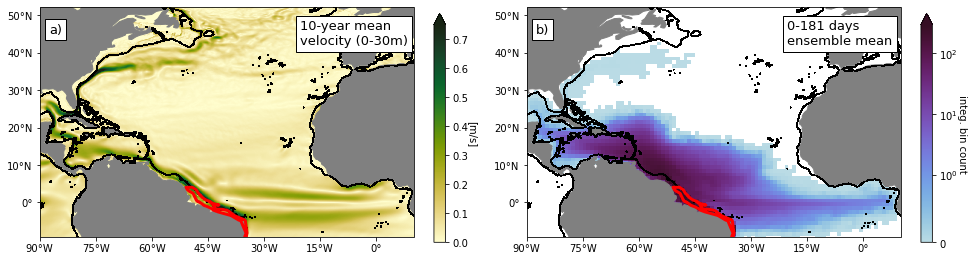

In [9]:
proj = ccrs.PlateCarree()

cb_pad = 0.05
cb_fraction = 0.047*0.6
textbox = ["10-year mean\nvelocity (0-30m)","0-181 days\nensemble mean"]
textbox2 = ["a)","b)"]

new_cmap = cmo.tools.crop_by_percent(cmo.cm.dense, 10, which='min', N=None)
formatter = LogFormatter(10, labelOnlyBase=False)
x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(16, 9))

skip = 80
qv_scale = 0.5
pc = ax[0].pcolormesh(ulon[x_ind], ulat[y_ind],  np.sqrt(u_mean**2+ v_mean**2), cmap = cmo.cm.speed, transform = proj, vmin = 0,vmax = 0.75)
cbar = fig.colorbar(pc, ax =ax[0], pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('[m/s]', rotation=270, labelpad = 9)
#qv = ax[0].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale =qv_scale, rasterized = True, #2.5
#                  scale_units='inches', width = .006,zorder = 2,
#                transform = proj)

#ax[0].quiverkey(qv, 1.21, 0.07, .2, r'$0.1 \frac{m}{s}$', labelpos='E', 
#                       coordinates='axes',rasterized = True,zorder = -1,);




pc = ax[1].pcolormesh(x_mesh,y_mesh,np.where(hm_brazil_180>0,hm_brazil_180,np.nan), cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=300, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[1], pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


for i, axs in enumerate(ax.flat):    
    axs.annotate(textbox[i],(-20.3,42.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.annotate(textbox2[i],(-87.5,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
    axs.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
   
    axs.plot(box_brazil.exterior.coords.xy[0],box_brazil.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
    axs.set_xticks(x_lines, crs=proj)
    axs.set_yticks(y_lines, crs=proj)
    axs.set_extent((-90,10,-6,40))
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 

skip = 80
qv_scale = 0.4

#qv = ax[0].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale =qv_scale, rasterized = True, #2.5
#                  scale_units='inches', width = .006,zorder = 2,
#                transform = proj)
#ax[1].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = qv_scale, rasterized = True, #2.5
#             scale_units='inches', width = .006,zorder = 2,
#                transform = proj)

#ax[0].quiverkey(qv, 1.25, 0.07, .1, r'$0.1 \frac{m}{s}$', labelpos='E', 
#                       coordinates='axes',rasterized = True,zorder = -1,);
plt.savefig('pics/americas_hm_brazil_shelf.png', dpi = 300, bbox_inches = 'tight')

In [10]:
#cape hatteras
ds,num = load_ds(2)
hm_ens_mean = calculate_heatmap(ds,lat_bins,lon_bins)/10
hm_hatteras_180 = hm_ens_mean.isel(obs = slice(0,181)).sum('obs')/181
hm_hatteras_full = hm_ens_mean.sum('obs')/362

loaded 37 files in zone 2


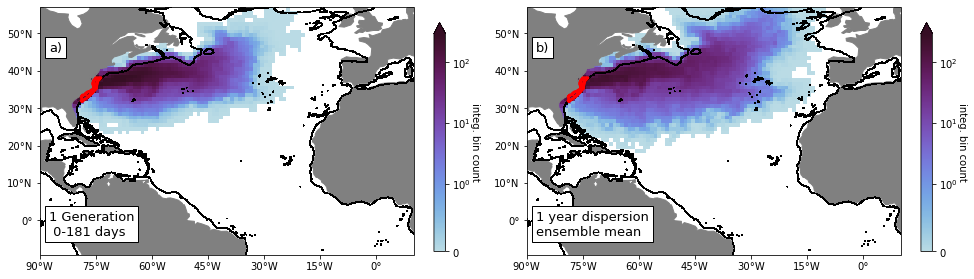

In [11]:
textbox = ["1 Generation\n 0-181 days","1 year dispersion\nensemble mean"]
textbox2 = ["a)","b)"]

new_cmap = cmo.tools.crop_by_percent(cmo.cm.dense, 10, which='min', N=None)
formatter = LogFormatter(10, labelOnlyBase=False)
x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(16, 9))


pc = ax[0].pcolormesh(x_mesh,y_mesh,np.where(hm_hatteras_180,hm_hatteras_180,np.nan), cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=300, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[0], pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


pc = ax[1].pcolormesh(x_mesh,y_mesh,np.where(hm_hatteras_full>0,hm_hatteras_full,np.nan), cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=300, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[1], pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


for i, axs in enumerate(ax.flat):    
    axs.annotate(textbox[i],(-87.5,-4),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.annotate(textbox2[i],(-87.5,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
    axs.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
   
    axs.plot(box_hatteras.exterior.coords.xy[0],box_hatteras.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
    axs.set_xticks(x_lines, crs=proj)
    axs.set_yticks(y_lines, crs=proj)
    axs.set_extent((-90,10,-6,45))
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 
plt.savefig('pics/americas_hm_hatteras_shelf.png', dpi = 300, bbox_inches = 'tight')

In [12]:
#newfoundland
ds,num = load_ds(3)
hm_ens_mean = calculate_heatmap(ds,lat_bins,lon_bins)/10
hm_newf_180 = hm_ens_mean.isel(obs = slice(0,181)).sum('obs')/181
hm_newf_full = hm_ens_mean.sum('obs')/362

loaded 40 files in zone 3


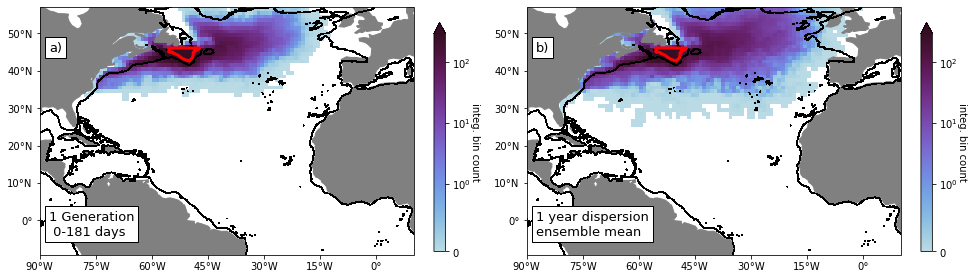

In [14]:
textbox = ["1 Generation\n 0-181 days","1 year dispersion\nensemble mean"]
textbox2 = ["a)","b)"]

new_cmap = cmo.tools.crop_by_percent(cmo.cm.dense, 10, which='min', N=None)
formatter = LogFormatter(10, labelOnlyBase=False)
x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(16, 9))


pc = ax[0].pcolormesh(x_mesh,y_mesh,np.where(hm_newf_180,hm_newf_180,np.nan), cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=300, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[0], pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


pc = ax[1].pcolormesh(x_mesh,y_mesh,np.where(hm_newf_full>0,hm_newf_full,np.nan), cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=300, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[1], pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


for i, axs in enumerate(ax.flat):    
    axs.annotate(textbox[i],(-87.5,-4),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.annotate(textbox2[i],(-87.5,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
    axs.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
   
    axs.plot(box_newfoundland.exterior.coords.xy[0],box_newfoundland.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
    axs.set_xticks(x_lines, crs=proj)
    axs.set_yticks(y_lines, crs=proj)
    axs.set_extent((-90,10,-6,45))
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 
plt.savefig('pics/americas_hm_newfoundland_shelf.png', dpi = 300, bbox_inches = 'tight')